# MLFlow 



## sources 

Source : 
* https://github.com/ksk0629/template_with_mlflow/blob/main/template_with_mlflow.ipynb 
* https://github.com/amesar/mlflow-examples 
* https://anderfernandez.com/en/blog/complete-mlflow-tutorial/ 
* https://towardsdatascience.com/from-dev-to-deployment-an-end-to-end-sentiment-classifier-app-with-mlflow-sagemaker-and-119043ea4203 
* https://medium.com/mlearning-ai/how-to-manage-an-end-to-end-machine-learning-project-with-mlflow-part-2-7d9b2958332d 
* https://github.com/datarevenue-berlin/OpenMLOps/blob/master/tutorials/basic-usage-of-jupyter-mlflow-and-prefect.md 
* https://towardsdatascience.com/end-to-end-ml-pipelines-with-mlflow-tracking-projects-serving-1b491bcdc25f

* https://medium.com/analytics-vidhya/serving-a-model-using-mlflow-8ba5db0a26c0 
* https://towardsdatascience.com/machine-learning-adventures-with-mlflow-64127713b0a1 
* https://dzlab.github.io/ml/2020/07/12/ml-ci-mlflow/ 

# Exemple Modele CNN MNIST

In [ ]:
from typing import List, Tuple
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

FLATTENED_SIZE: int = 784  # dimension of flattened one mnist data

In [ ]:
def load_scaled_mnist(validation_size: float) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """Load and separate scaled MNIST dataset into ones for training, evaluating, and testing.
    :param float validation_size: ratio of validation dataset size
    :return List[numpy.ndarray] train_dataset: dataset for training whose length is 2, the first element is data and the second one is the labels
    :return List[numpy.ndarray] validation_dataset: dataset for evaluating whose length is 2, the first element is data and the second one is the labels
    :return List[numpy.ndarray] test_dataset: dataset for testing whose length is 2, the first element is data and the second one is the labels
    """
    # load mnist data
    (x, y), (test_data, test_labels) = mnist.load_data()

    # Separate x into a training dataset and a validation dataset
    train_data, validation_data, train_labels, validation_labels = train_test_split(x, y, test_size=validation_size)

    # Flatten all of data
    train_data = train_data.reshape(-1, FLATTENED_SIZE)
    validation_data = validation_data.reshape(-1, FLATTENED_SIZE)
    test_data = test_data.reshape(-1, FLATTENED_SIZE)
    all_data = np.concatenate([train_data, validation_data, test_data])

    # Scale those data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_all_data = scaler.fit_transform(all_data)
    scaled_train_data = scaled_all_data[:len(train_data)]
    scaled_validation_data = scaled_all_data[len(train_data):len(train_data)+len(validation_data)]
    scaled_test_data = scaled_all_data[len(train_data)+len(validation_data):]
    
    # Check the lengths of data
    assert len(train_data) == len(scaled_train_data), "The length of train_data is not same as one of scaled_train_data."
    assert len(validation_data) == len(scaled_validation_data), "The length of validation_data is not same as one of scaled_validation_data."
    assert len(test_data) == len(scaled_test_data), "The length of test_data is not same as one of scaled_test_data."

    # Make list whose length two, the first one is data and another is label
    train_dataset = [scaled_train_data, train_labels]
    validation_dataset = [scaled_validation_data, validation_labels]
    test_dataset = [scaled_test_data, test_labels]

    return train_dataset, validation_dataset, test_dataset

In [ ]:
#load_scaled_mnist(validation_size=0.2)

In [ ]:
def train_and_evaluate_cnn(seed: int, validation_size: float,
                           n_hidden: int, n_features: int,
                           epochs: int, batch_size: int, learning_rate: float) -> None:
    """Train and evaluate CNN on sclaed MNIST datasets.
    :param int seed: random seed to fix random values
    :param float validation_size: ratio of validation dataset size
    :param int n_hidden: number of hidden layers
    :param int n_features: number of features
    :param int epochs: number of epochs
    :param int batch_size: training batch size
    :param float learning_rate: leraning rate
    """

    # Fix and log seed value
    np.random.seed(seed)

    # Get scaled mnist dataset and log the validation size
    train_dataset, validation_dataset, test_dataset = load_scaled_mnist(validation_size=validation_size)

    # Expand those dataset into data and labels
    train_data, train_labels = train_dataset
    validation_data, validation_labels = validation_dataset
    test_data, test_labels = test_dataset

    # Convert numerical labels into categorical labels
    train_labels = to_categorical(train_labels)
    validation_labels = to_categorical(validation_labels)

    # Create the model
    model = Sequential()
    model.add(Dense(n_hidden, activation="relu", input_shape=(n_features,)))
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=["mae", "accuracy"])

    # Fit the model
    history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, verbose=True,
              callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)],
              validation_data=(validation_data, validation_labels))

    # Evaluate the model and log the accuracy
    test_predicted = np.argmax(model.predict(test_data), axis=1)
    accuracy = sum(test_predicted == test_labels) / len(test_predicted)

    print(f"accuracy is {accuracy}.")

    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, metric in enumerate(['accuracy', 'loss']):
      ax[i].plot(history.history[metric])
      ax[i].plot(history.history["val_" + metric])
      ax[i].set_title("Model {}".format(metric))
      ax[i].set_xlabel("epochs")
      ax[i].set_ylabel(metric)
      ax[i].legend(["train", "val"])
    plt.show() 

Epoch 1/5
6000/6000 [==============================] - 29s 5ms/step - loss: 0.4624 - mae: 0.0332 - accuracy: 0.8824 - val_loss: 0.3057 - val_mae: 0.0210 - val_accuracy: 0.9250
Epoch 2/5
6000/6000 [==============================] - 28s 5ms/step - loss: 0.3123 - mae: 0.0220 - accuracy: 0.9254 - val_loss: 0.3164 - val_mae: 0.0210 - val_accuracy: 0.9266
Epoch 3/5
6000/6000 [==============================] - 32s 5ms/step - loss: 0.3029 - mae: 0.0202 - accuracy: 0.9310 - val_loss: 0.3117 - val_mae: 0.0193 - val_accuracy: 0.9291
Epoch 4/5
6000/6000 [==============================] - 29s 5ms/step - loss: 0.2805 - mae: 0.0185 - accuracy: 0.9366 - val_loss: 0.2736 - val_mae: 0.0175 - val_accuracy: 0.9384
Epoch 5/5
313/313 [==============================] - 1s 2ms/step
accuracy is 0.9405.


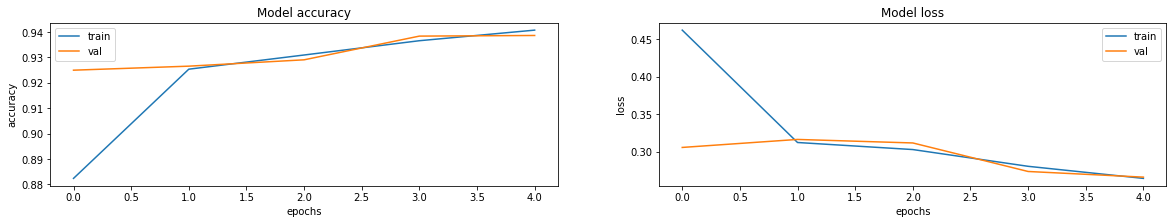

In [ ]:
# lancement entrainement
seed=57
validation_size=0.2
n_hidden=100
n_features=784
epochs=5
batch_size=8
learning_rate=0.01

train_and_evaluate_cnn(seed, validation_size,
                           n_hidden, n_features,
                           epochs, batch_size, learning_rate)

# Exemple Modele CNN MNIST avec MLFLOW 

## INSTALL ET RUN MLFLOW

In [ ]:
# install MLFLOW / ngrock

import importlib

if importlib.util.find_spec('mlflow') is None:
  !pip install mlflow

if importlib.util.find_spec('pyngrok') is None:
  !pip install pyngrok

# !pip install -r requirements.txt

In [ ]:
# Run mlflow
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://cd5a-34-73-115-85.ngrok.io


## ajouter l'instrumentation du code

In [ ]:
import mlflow
import mlflow.keras

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000/')

In [ ]:
def train_and_evaluate_cnn(experiment_name: str, run_name: str,
                           seed: int, validation_size: float,
                           n_hidden: int, n_features: int,
                           epochs: int, batch_size: int, learning_rate: float) -> None:
    """Train and evaluate CNN on sclaed MNIST datasets.
    :param str experiment_name: experiment name, which is logged to mlflow
    :param str run_name: run name, which is logged to mlflow
    :param int seed: random seed to fix random values
    :param float validation_size: ratio of validation dataset size
    :param int n_hidden: number of hidden layers
    :param int n_features: number of features
    :param int epochs: number of epochs
    :param int batch_size: training batch size
    :param float learning_rate: leraning rate
    """
    # Set an experiment name
    mlflow.set_experiment(experiment_name)

    mlflow.set_tag("version.mlflow", mlflow.__version__)
    mlflow.set_tag("version.keras", keras.__version__)
    mlflow.set_tag("version.tensorflow", tf.__version__)

    with mlflow.start_run(run_name=run_name, nested=True):
        # Log automatically
        mlflow.keras.autolog()

        # Fix and log seed value
        np.random.seed(seed)
        mlflow.log_param("numpy seed", seed)

        # Get scaled mnist dataset and log the validation size
        train_dataset, validation_dataset, test_dataset = load_scaled_mnist(validation_size=validation_size)
        mlflow.log_param("validation size", validation_size)

        # Expand those dataset into data and labels
        train_data, train_labels = train_dataset
        validation_data, validation_labels = validation_dataset
        test_data, test_labels = test_dataset

        # Convert numerical labels into categorical labels
        train_labels = to_categorical(train_labels)
        validation_labels = to_categorical(validation_labels)

        # Create the model
        model = Sequential()
        model.add(Dense(n_hidden, activation="relu", input_shape=(n_features,)))
        model.add(Dense(n_hidden, activation="relu"))
        model.add(Dense(n_hidden, activation="relu"))
        model.add(Dense(10, activation="softmax"))
        model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=["mae", "accuracy"])

        # mlflow.keras.log_model(model, "tensorflow-model", registered_model_name=model_name)

        # Fit the model
        history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, verbose=True,
                  callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)],
                  validation_data=(validation_data, validation_labels))

        # Evaluate the model and log the accuracy
        test_predicted = np.argmax(model.predict(test_data), axis=1)
        accuracy = sum(test_predicted == test_labels) / len(test_predicted)
        mlflow.log_metric("accuracy", accuracy)

        print(f"accuracy is {accuracy}.")

        fig, ax = plt.subplots(1, 2, figsize=(20, 3))
        ax = ax.ravel()

        for i, metric in enumerate(['accuracy', 'loss']):
          ax[i].plot(history.history[metric])
          ax[i].plot(history.history["val_" + metric])
          ax[i].set_title("Model {}".format(metric))
          ax[i].set_xlabel("epochs")
          ax[i].set_ylabel(metric)
          ax[i].legend(["train", "val"])
        plt.show() 
        
        mlflow.log_figure(fig, "model-accuracy-loss.png")

In [ ]:
#mlflow.set_tag("version.mlflow", mlflow.__version__)
#mlflow.set_tag("version.keras", keras.__version__)
#mlflow.set_tag("version.tensorflow", tf.__version__)
#mlflow.set_tag("version.sklearn", sklearn.__version__)
#mlflow.set_tag("version.os", platform.system()+" - "+platform.release())
#mlflow.set_tag("mlflow_custom_log", mlflow_custom_log)
#mlflow.set_tag("mlflow_keras.autolog", keras_autolog)
#mlflow.set_tag("mlflow_tensorflow.autolog", tensorflow_autolog)

### entrainement #1

2023/03/02 16:21:27 INFO mlflow.tracking.fluent: Experiment with name 'mnist with cnn' does not exist. Creating a new experiment.


Epoch 1/5
   1/6000 [..............................] - ETA: 2:07:13 - loss: 2.3948 - mae: 0.1816 - accuracy: 0.0000e+00

6000/6000 [==============================] - 31s 5ms/step - loss: 0.4529 - mae: 0.0336 - accuracy: 0.8806 - val_loss: 0.3465 - val_mae: 0.0235 - val_accuracy: 0.9119
Epoch 2/5
6000/6000 [==============================] - 32s 5ms/step - loss: 0.3443 - mae: 0.0238 - accuracy: 0.9194 - val_loss: 0.4146 - val_mae: 0.0285 - val_accuracy: 0.9008
Epoch 3/5
6000/6000 [==============================] - 32s 5ms/step - loss: 0.3195 - mae: 0.0216 - accuracy: 0.9257 - val_loss: 0.4999 - val_mae: 0.0319 - val_accuracy: 0.8733
Epoch 4/5
6000/6000 [==============================] - 32s 5ms/step - loss: 0.3310 - mae: 0.0215 - accuracy: 0.9244 - val_loss: 0.4205 - val_mae: 0.0243 - val_accuracy: 0.9124
Epoch 5/5
1/1 [==============================] - 0s 274ms/step


2023/03/02 16:25:06 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.4+cuda11.cudnn82) contains a local version label (+cuda11.cudnn82). MLflow logged a pip requirement for this package as 'jaxlib==0.4.4' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


313/313 [==============================] - 1s 2ms/step
accuracy is 0.923.


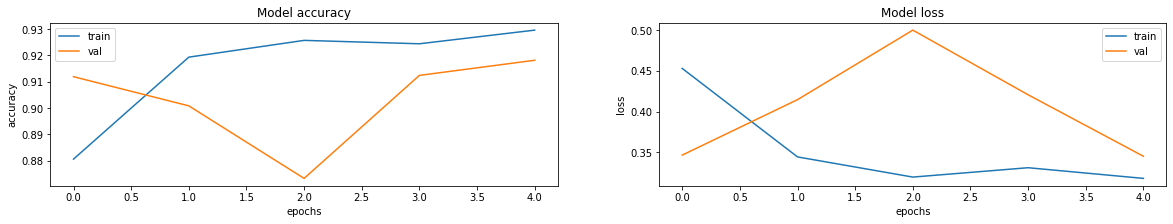

In [ ]:
# lancement entrainement
experiment_name = "mnist with cnn"
run_name = "first run"
seed=57
validation_size=0.2
n_hidden=100
n_features=784
epochs=5
batch_size=8
learning_rate=0.01

train_and_evaluate_cnn(experiment_name, run_name,
                           seed, validation_size,
                           n_hidden, n_features,
                           epochs, batch_size, learning_rate)

### entrainement #2

Epoch 1/5
   1/6000 [..............................] - ETA: 4:32:06 - loss: 2.2952 - mae: 0.1796 - accuracy: 0.2500

6000/6000 [==============================] - 66s 11ms/step - loss: 0.5205 - mae: 0.0358 - accuracy: 0.8701 - val_loss: 0.4286 - val_mae: 0.0350 - val_accuracy: 0.8923
Epoch 2/5
6000/6000 [==============================] - 52s 9ms/step - loss: 0.3443 - mae: 0.0238 - accuracy: 0.9170 - val_loss: 0.2750 - val_mae: 0.0181 - val_accuracy: 0.9365
Epoch 3/5
6000/6000 [==============================] - 62s 10ms/step - loss: 0.3248 - mae: 0.0213 - accuracy: 0.9267 - val_loss: 0.3088 - val_mae: 0.0199 - val_accuracy: 0.9268
Epoch 4/5
6000/6000 [==============================] - 53s 9ms/step - loss: 0.3165 - mae: 0.0210 - accuracy: 0.9267 - val_loss: 0.2644 - val_mae: 0.0162 - val_accuracy: 0.9452
Epoch 5/5
1/1 [==============================] - 0s 100ms/step


2023/03/02 16:30:01 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.4+cuda11.cudnn82) contains a local version label (+cuda11.cudnn82). MLflow logged a pip requirement for this package as 'jaxlib==0.4.4' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


313/313 [==============================] - 1s 3ms/step
accuracy is 0.918.


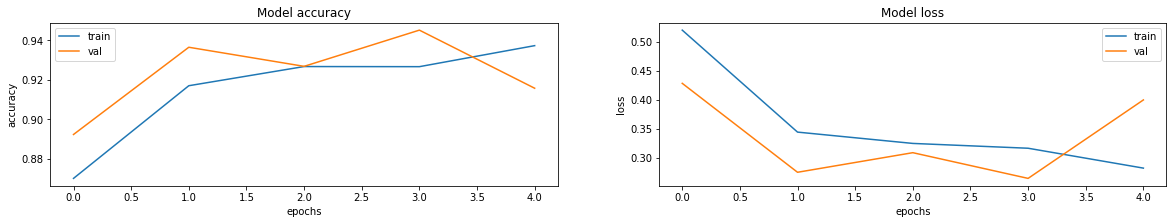

In [ ]:
# lancement entrainement
experiment_name = "mnist with cnn"
run_name = "second run"
seed=57
validation_size=0.2
n_hidden=200
n_features=784
epochs=5
batch_size=8
learning_rate=0.01

train_and_evaluate_cnn(experiment_name, run_name,
                           seed, validation_size,
                           n_hidden, n_features,
                           epochs, batch_size, learning_rate)

### entrainement #3

Epoch 1/5
   1/6000 [..............................] - ETA: 2:10:22 - loss: 2.4075 - mae: 0.1814 - accuracy: 0.1250

6000/6000 [==============================] - 51s 8ms/step - loss: 0.9196 - mae: 0.0683 - accuracy: 0.7469 - val_loss: 0.7140 - val_mae: 0.0562 - val_accuracy: 0.8223
Epoch 2/5
6000/6000 [==============================] - 50s 8ms/step - loss: 0.8887 - mae: 0.0710 - accuracy: 0.7291 - val_loss: 0.9485 - val_mae: 0.0742 - val_accuracy: 0.7042
Epoch 3/5
6000/6000 [==============================] - 46s 8ms/step - loss: 0.9957 - mae: 0.0866 - accuracy: 0.6421 - val_loss: 1.0163 - val_mae: 0.0773 - val_accuracy: 0.6731
Epoch 4/5
6000/6000 [==============================] - 48s 8ms/step - loss: 0.9318 - mae: 0.0815 - accuracy: 0.6605 - val_loss: 1.4747 - val_mae: 0.0953 - val_accuracy: 0.5725
Epoch 5/5
1/1 [==============================] - 0s 104ms/step


2023/03/02 16:34:36 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.4+cuda11.cudnn82) contains a local version label (+cuda11.cudnn82). MLflow logged a pip requirement for this package as 'jaxlib==0.4.4' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


313/313 [==============================] - 2s 5ms/step
accuracy is 0.6548.


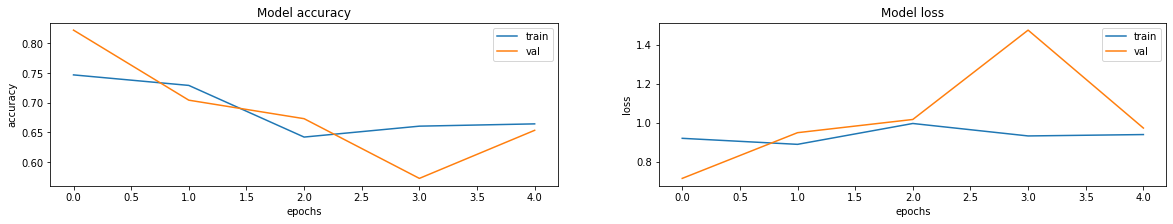

In [ ]:
# lancement entrainement
experiment_name = "mnist with cnn"
run_name = "third run"
seed=57
validation_size=0.2
n_hidden=200
n_features=784
epochs=5
batch_size=8
learning_rate=0.02

train_and_evaluate_cnn(experiment_name, run_name,
                           seed, validation_size,
                           n_hidden, n_features,
                           epochs, batch_size, learning_rate)

In [ ]:
!ls -l 
!ls -l mlruns/

total 12
drwxr-xr-x 4 root root 4096 Mar  2 10:48 mlartifacts
drwxr-xr-x 6 root root 4096 Mar  2 10:22 mlruns
drwxr-xr-x 1 root root 4096 Feb 28 14:45 sample_data
total 12
drwxr-xr-x 3 root root 4096 Mar  2 10:21 0
drwxr-xr-x 7 root root 4096 Mar  2 12:31 109670326709967841
drwxr-xr-x 2 root root 4096 Mar  2 10:21 models


## Maintenant, on va voir dans MLFlow UI 

In [ ]:
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://cd5a-34-73-115-85.ngrok.io


## rejouer / reproduire / collaborer

In [ ]:
# exemple possible : mlflow run https://github.com/mlflow/mlflow-example.git -P alpha=5.0

## API possible pour interagir avec MLFlow

### model register

In [ ]:
# par exemple,
# On envoie le modèle vers le registry

import mlflow
run_id= "740cc0c5f11145b481506dbf407d6932"
artifact_name = "model"
model_name = "modeleB"
result = mlflow.register_model(f"runs:/{run_id}/{artifact_name}", model_name)
print(result.version)

Registered model 'modeleB' already exists. Creating a new version of this model...
2023/03/02 18:15:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modeleB, version 2


2


Created version '2' of model 'modeleB'.


### promotion en staging

In [ ]:
# On tag le modèle en version staging

version = 2

client = mlflow.tracking.client.MlflowClient()

client.transition_model_version_stage(

	name=model_name, version=int(version), stage="Staging"

)


<ModelVersion: creation_timestamp=1677780939769, current_stage='Staging', description='', last_updated_timestamp=1677780977027, name='modeleB', run_id='740cc0c5f11145b481506dbf407d6932', run_link='', source='mlflow-artifacts:/987383362440272631/740cc0c5f11145b481506dbf407d6932/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>

### rechargement et execution du modele pour une version d'expérimentation

/usr/local/lib/python3.8/dist-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 0s 154ms/step


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

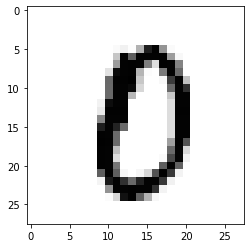

In [ ]:
import mlflow.sklearn
from keras.datasets import mnist

#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
test_X = test_X.reshape(-1, FLATTENED_SIZE)
plt.imshow(test_X[55].reshape(28, 28),cmap='Greys')
data = test_X[55].reshape(-1, FLATTENED_SIZE).astype('float64')

# loading model
model = mlflow.pyfunc.load_model(f"runs:/{run_id}/{artifact_name}")

# Use the model for predictions in your application
model.predict(data)

### chargement et exécution de la version du modèle de Production

In [ ]:


# Since it's a registered model in Production, we can load it like this now!
# No need for model URIs
stage = 'Production'
model_registry_path = f'models:/{model_name}/{stage}'
production_model = mlflow.pyfunc.load_model(model_registry_path)



production_model.predict(data)

/usr/local/lib/python3.8/dist-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 0s 113ms/step


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### créer un endpoint pour une version du modèle

In [ ]:
#!ls -l mlartifacts/109670326709967841/c0d697948ef844fd8b8375d8f0333171/artifacts/model
#!ls -l mlruns/109670326709967841/**/artifacts/





In [ ]:
#!mlflow models serve -m mlartifacts/109670326709967841/c0d697948ef844fd8b8375d8f0333171/artifacts/model --port 5050
!mlflow models serve -m ./mlartifacts/109670326709967841/c0d697948ef844fd8b8375d8f0333171/artifacts/model -p 5050 --no-conda

2023/03/02 14:33:17 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2023/03/02 14:33:17 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 127.0.0.1:5050 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2023-03-02 14:33:17 +0000] [78143] [INFO] Starting gunicorn 20.1.0
[2023-03-02 14:33:17 +0000] [78143] [INFO] Listening at: http://127.0.0.1:5050 (78143)
[2023-03-02 14:33:17 +0000] [78143] [INFO] Using worker: sync
[2023-03-02 14:33:17 +0000] [78145] [INFO] Booting worker with pid: 78145
2023-03-02 14:33:22.184149: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-02 14:33:22.184345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

In [ ]:
import requests
import pandas as pd

url = 'http://localhost:5050/invocations'

headers = {'Content-type': 'application/json'}
data = pd.DataFrame(test_X).to_json(orient='split')

resp = requests.post(
    url,
    headers=headers,
    data = data
    )

resp.content

ConnectionError: ignored

In [ ]:
# Prediction endpoint
url = 'http://127.0.0.1:5001/invocations'

# Prepare the data to be sent to API
example = data[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
to_send = example.to_dict(orient='split')
to_send.pop("index", None)

# Preprocess the example
response = requests.post(url=url, data=json.dumps({"dataframe_split" :to_send}), headers={"Content-type": "application/json"})

# Load the response
response_json = json.loads(response.text)
print(response_json)

In [ ]:
# Dockerfile 
FROM python:3.8.12-slim-buster

RUN pip install mlflow pandas flask cloudpickle==1.6.0 psutil==5.8.0 scikit-learn==0.24.1

WORKDIR /model 

COPY ./mlruns/1/ede4cc6ace71468ab2e881dc14d25f6b/artifacts/models/ .

CMD ["mlflow","models","serve","-m","./","-h","0.0.0.0","-p","5000","--no-conda"]
EXPOSE 5000

In [ ]:
# Build a Docker image named 'my-image-name' that serves the model from run 'some-run-uuid'
# at run-relative artifact path 'my-model'
mlflow models build-docker --model-uri "runs:/some-run-uuid/my-model" --name "my-image-name"
# Serve the model
docker run -p 5001:8080 "my-image-name"

### CI et Release

exemple de code pour recherche le modele avec la meilleure "accuacy"

In [ ]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType

client = MlflowClient()
# Parametrizing the right experiment path using widgets
experiment_name = 'Default'
experiment = client.get_experiment_by_name(experiment_name)
experiment_ids = [experiment.experiment_id]
print("Experiment IDs:", experiment_ids)

# Setting the decision criteria for a best run
query = "metrics.accuracy > 0.8"
runs = client.search_runs(experiment_ids, query, ViewType.ALL)

# Searching throught filtered runs to identify the best_run and build the model URI to programmatically reference later
accuracy_high = None
best_run = None
for run in runs:
  if (accuracy_high == None or run.data.metrics['accuracy'] > accuracy_high):
    accuracy_high = run.data.metrics['accuracy']
    best_run = run
run_id = best_run.info.run_id
print('Highest Accuracy: ', accuracy_high)
print('Run ID: ', run_id)

model_uri = "runs:/" + run_id + "/model"

exemple de code qui fait la promotion en Production automatiquement du modele avec la meilleure "accuracy"

In [ ]:
import time

# Check if model is already registered
model_name = "News Classification Model"
try:
  registered_model = client.get_registered_model(model_name)
except:
  registered_model = client.create_registered_model(model_name)

# Create the model source
model_source = f"{best_run.info.artifact_uri}/model"
print(model_source)

# Archive old production model
max_version = 0
for mv in client.search_model_versions("name='Diabetes Progression Model'"):
  current_version = int(dict(mv)['version'])
  if current_version > max_version:
    max_version = current_version
  if dict(mv)['current_stage'] == 'Production':
    version = dict(mv)['version']
    client.transition_model_version_stage(model_name, version, stage='Archived')

# Create a new version for this model with best metric (accuracy)
client.create_model_version(model_name, model_source, run_id)
# Check the status of the created model version (it has to be READY)
status = None
while status != 'READY':
  for mv in client.search_model_versions(f"run_id='{run_id}'"):
    status = mv.status if int(mv.version)==max_version + 1 else status
  time.sleep(5)

# Promote the model version to production stage
client.transition_model_version_stage(model_name, max_version + 1, stage='Production')

# CONCLUSION

## Recap

![](https://www.databricks.com/wp-content/uploads/2021/02/mlflow-components2.png)

![](https://www.databricks.com/wp-content/uploads/2020/04/databricks-adds-access-control-to-mlflow-model-registry_01.jpg)

![](https://www.databricks.com/wp-content/uploads/2020/06/blog-mlflow-model-1.png)

![](https://dzlab.github.io/assets/2020/20200712-mlops-mlflow.png)

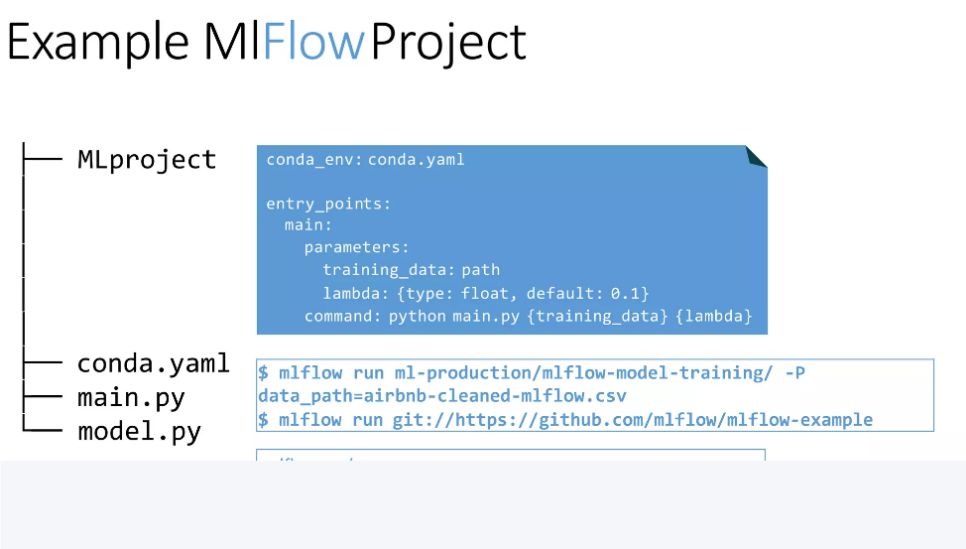

## indus ML et MLOps

* https://blog.octo.com/gestion-de-versions-en-delivery-machine-learning/ 
* https://martinfowler.com/articles/cd4ml.html 

## ressources 


https://www.mlflow.org/docs/latest/tutorials-and-examples/index.html 
https://www.youtube.com/watch?v=-mINS6NyOgA 